In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook

from itertools import product

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

import warnings
warnings.filterwarnings('ignore')


In [10]:
def df_investigate(df):
  info = pd.DataFrame(df.count(), columns=['filled'])
  info['filled %'] = round(info['filled'] / len(df), 4)*100
  info['nunique'] = df.nunique()
  info['uniques'] = np.nan
  info['dtypes'] = df.dtypes
  for idx, row in info.iterrows():
    if row['nunique'] < 10:
      info.loc[idx, 'uniques'] = str(list(df[idx].unique()))
  return info

In [11]:
import boto3

session = boto3.Session() # Grabs session details directly from aws configuration in EC2 instance running the Notebook server
s3r = session.resource("s3")
bucket = s3r.Bucket('aida-project')
files=[]
for obj in bucket.objects.all():
  if obj.key.startswith("Covid"):
#    print(obj.key)
    if obj.key.endswith("csv"):
        files.append(obj.key)
for i,file in enumerate(files):
    print(i,"\t",file)

0 	 Covid-19/1/owid-covid-data.csv
1 	 Covid-19/2/covid-19-at.csv
2 	 Covid-19/2/covid-19-be.csv
3 	 Covid-19/2/covid-19-ch.csv
4 	 Covid-19/2/covid-19-cz.csv
5 	 Covid-19/2/covid-19-de.csv
6 	 Covid-19/2/covid-19-ecdc.csv
7 	 Covid-19/2/covid-19-england.csv
8 	 Covid-19/2/covid-19-fr.csv
9 	 Covid-19/2/covid-19-hu.csv
10 	 Covid-19/2/covid-19-ie.csv
11 	 Covid-19/2/covid-19-it.csv
12 	 Covid-19/2/covid-19-nl.csv
13 	 Covid-19/2/covid-19-no.csv
14 	 Covid-19/2/covid-19-pl.csv
15 	 Covid-19/2/covid-19-scotland.csv
16 	 Covid-19/2/covid-19-se.csv
17 	 Covid-19/2/covid-19-si.csv
18 	 Covid-19/2/covid-19-uk.csv
19 	 Covid-19/2/covid-19-wales.csv
20 	 Covid-19/3/time_series_covid19_confirmed_US.csv
21 	 Covid-19/3/time_series_covid19_confirmed_global.csv
22 	 Covid-19/3/time_series_covid19_deaths_US.csv
23 	 Covid-19/3/time_series_covid19_deaths_global.csv
24 	 Covid-19/3/time_series_covid19_recovered_global.csv
25 	 Covid-19/4/covid_jpn_metadata.csv
26 	 Covid-19/4/covid_jpn_prefecture.csv

In [12]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from itertools import product
import warnings
warnings.filterwarnings('ignore')

In [13]:
# what to test?
# we know: seasonal and non-seasonal integration Parameters = 1
# lenght of season=12
# find: p,P,q,Q

p = range(1, 2, 1)
d = 1
q = range(1, 2, 1)
P = range(4, 9, 1)
D = 1
Q = range(1, 2, 1)
s = 12
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(parameters_list)
print(len(parameters_list))

[(1, 1, 4, 1), (1, 1, 5, 1), (1, 1, 6, 1), (1, 1, 7, 1), (1, 1, 8, 1)]
5


In [14]:
file_nr = 0
selected_file = files[file_nr]

file_check = "s3://" + bucket.name + "/" + selected_file
df = pd.read_csv(file_check, error_bad_lines=False)
df.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,ABW,North America,Aruba,2020-03-13,2.0,2.0,NaN,NaN,0.0,NaN,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN
1,ABW,North America,Aruba,2020-03-19,NaN,NaN,0.286,NaN,NaN,0.0,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN
2,ABW,North America,Aruba,2020-03-20,4.0,2.0,0.286,NaN,0.0,0.0,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN


In [15]:
# dtype: object
# iso_code and continent: nan -> other
df_1 = df.copy()
cols_na = ['iso_code', 'continent','tests_units']
replace_na = ['Other','Other','Unknown']
for i in range(len(cols_na)):
    df_1[cols_na[i]] = df_1[cols_na[i]].fillna(replace_na[i])

# total_cases = prev value, new_cases = 0, new_cases_smoothed = following value, new_deaths = 0, total_deaths = 0 (check if missing value inbetween)
# new_deaths_smoothed = following value, for remaining new_deaths_smoothed and new_cases_smoothed set previous
df_2 = df_1.copy()
df_2['total_cases'] = df_2['total_cases'].fillna(method='ffill')
df_2['new_cases'] = df_2['new_cases'].fillna(0)
df_2['new_deaths'] = df_2['new_deaths'].fillna(0)
df_2['total_deaths'] = df_2['total_deaths'].fillna(0)
df_2['new_cases_smoothed'] = df_2['new_cases_smoothed'].fillna(method='bfill')
df_2['new_deaths_smoothed'] = df_2['new_deaths_smoothed'].fillna(method='bfill')
df_2['new_cases_smoothed'] = df_2['new_cases_smoothed'].fillna(method='ffill')
df_2['new_deaths_smoothed'] = df_2['new_deaths_smoothed'].fillna(method='ffill')

df_cleaned = df_2.copy()
iso_code='ABW'
df_iso=df_cleaned[df_cleaned['iso_code'] == iso_code]

In [16]:
def optimize_SARIMA(parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        print(param)
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            print("problem")
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [60]:
# what to test?
# we know: seasonal and non-seasonal integration Parameters = 1
# lenght of season=12
# find: p,P,q,Q

p = range(1, 2, 1)
d = 1
q = range(1, 2, 1)
P = range(1, 3, 1)
D = 1
Q = range(1, 2, 1)
s = 7
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(parameters_list)
print(len(parameters_list))

[(1, 1, 1, 1), (1, 1, 2, 1)]
2


In [61]:
param = parameters_list[1]

In [62]:
df_sarima = df_iso.reset_index()['new_cases']
model = SARIMAX(df_sarima, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)

In [63]:
model.aic

2206.259056788727

In [64]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                         new_cases   No. Observations:                  257
Model:             SARIMAX(1, 1, 1)x(2, 1, 1, 7)   Log Likelihood               -1097.130
Date:                           Tue, 01 Dec 2020   AIC                           2206.259
Time:                                   10:14:49   BIC                           2227.364
Sample:                                        0   HQIC                          2214.754
                                           - 257                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1335      0.080      1.666      0.096      -0.024       0.291
ma.L1         -0.7846      0.055    -14.186      0.000      -0.893      -0.676
ar.S.L7        0.2827      0.069      4.105      0.000       0.148       0.418
ar.S.L14       0.1035      0.062      1.680      0.093      -0.017       0.224
ma.S.L7       -0.9997      7.006     -0.143      0.887     -14.732      12.733
sigma2       362.1499   2527.448      0.143      0.886   -4591.557    5315.856
===================================================================================
Ljung-Box (Q):                      104.64   Jarque-Bera (JB):              1941.29
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              42.49   Skew:                             1.54
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

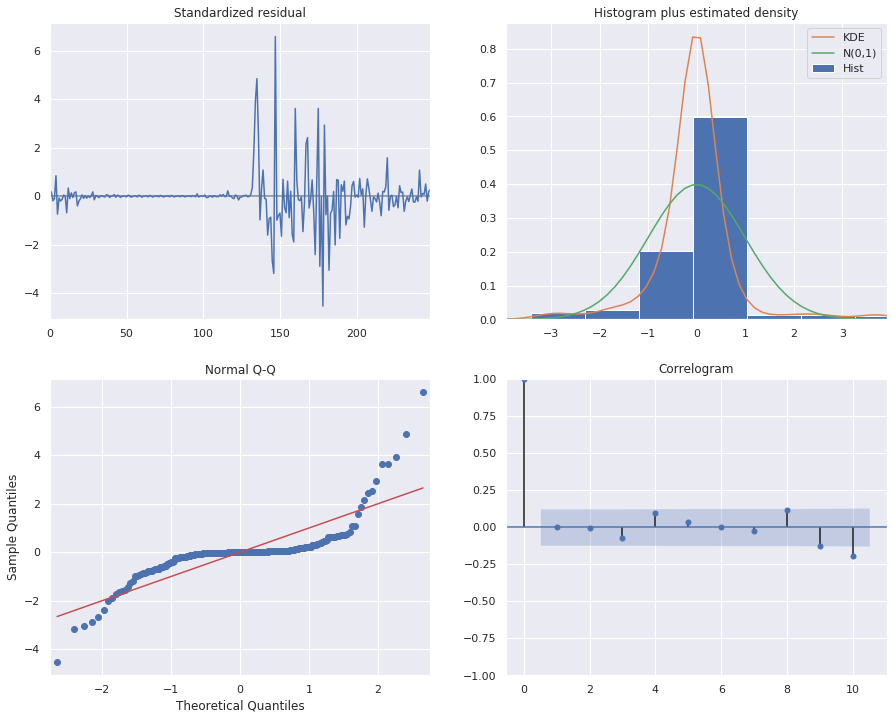

In [65]:
model.plot_diagnostics(figsize=(15,12));

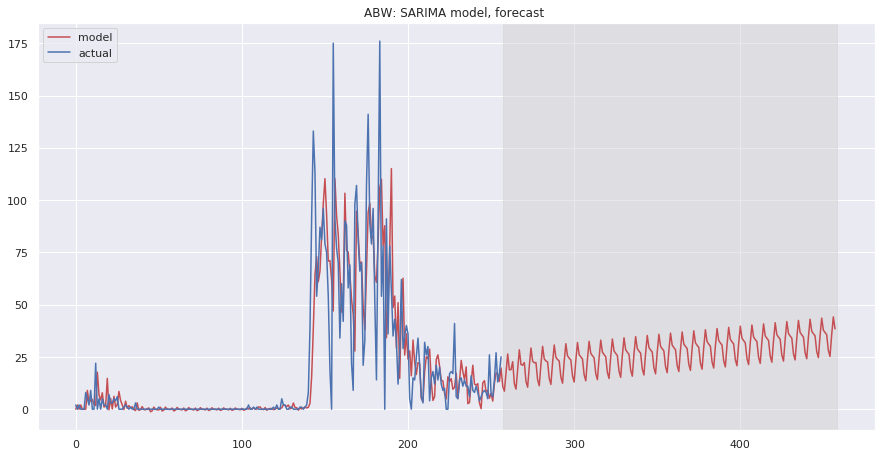

In [66]:

df_iso['arima_model'] = model.fittedvalues
#df_iso['arima_model'][:12] = np.NaN

forecast = model.predict(start=df_iso.shape[0], end=df_iso.shape[0] + 200)
forecast = df_iso['arima_model'].append(forecast)
plt.figure(figsize=(15, 7.5))
plt.plot(range(len(forecast)),forecast, color='r', label='model')
plt.axvspan(len(df_iso), len(forecast), alpha=0.5, color='lightgrey')
plt.plot(range(len(df_iso)),df_iso['new_cases'], label='actual')
plt.legend()
"""
shift_line=1
st=(y_end-y_start+1)*12
max0=max(forecast[st:st+13])+shift_line
max1=max(forecast[-13:-1])+shift_line
min0=min(forecast[st:st+13])-shift_line
min1=min(forecast[-13:-1])-shift_line
plt.plot([len(df_iso),len(forecast)],[max0,max1],c='black')
plt.plot([len(df_iso),len(forecast)],[max0,max0],c='black',linestyle='dotted')
plt.plot([len(df_iso),len(forecast)],[min0,min1],c='black')
plt.plot([len(df_iso),len(forecast)],[min0,min0],c='black',linestyle='dotted')
#plt.lines(min0,min1,c='black')
"""

plt.title(f"{iso_code}: SARIMA model, forecast ")
plt.show()

In [68]:
# what to test?
# we know: seasonal and non-seasonal integration Parameters = 1
# lenght of season=12
# find: p,P,q,Q

p = range(1, 10, 1)
d = 1
q = range(1, 2, 1)
P = range(1, 2, 1)
D = 1
Q = range(1, 2, 1)
s = 7
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(parameters_list)
print(len(parameters_list))

[(1, 1, 1, 1), (2, 1, 1, 1), (3, 1, 1, 1), (4, 1, 1, 1), (5, 1, 1, 1), (6, 1, 1, 1), (7, 1, 1, 1), (8, 1, 1, 1), (9, 1, 1, 1)]
9


In [67]:
# SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)

result_df = optimize_SARIMA(parameters_list, 1, 1, 12, dat_optimize['Temp'])

[(1, 1, 1, 1), (1, 1, 2, 1)]
